In [1]:
!pip install nltk
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/cor

# How was good their flight?

**Hello, and welcome to my notebook! We are so close to hired by some kind of company called, Anor Londo as a Data Scientist who have to do very interesting task. Our job is to build a model which can detect bad reviews from millions of reviews(because Anor Londo is like the biggest company in the world) and delete them immediately(I know, it's terrible, deleting bad reviews. But hey! They're ruling the world, who can question them?). Right now me and some other people(like a hundred) trying to build the same model in order to successfully detect and delete the bad reviews. Only one us can hired by Anor Londo.**

Note: This notebook is created with the purpose  of 'learning with entertaining.' I'm a learner too and I just want to show you what I've learned so far in my ML journey. Please keep reading, I'm sure that you'll also learn something from this notebook.

# Greeting the Data!!

Before building the model, we have to meet the data that given us.

In [2]:
reviews = pd.read_csv('/kaggle/input/airline-reviews/Airline_Reviews.csv')
reviews.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


We looked the dataset, and turns out that this reviews belong to different Aviation company which Anor Londo has(Just in our Dystopian world)! We can choose 'Overall_Rating' column as our model's label. But it isn't necessary to predict exact rating point for each review. We just want to predict how good or how bad the review is.

# Data Cleaning

In [3]:
#Let's look at the unique values in 'Overall_Rating' column
reviews['Overall_Rating'].unique() 

array(['9', '1', '8', '2', '3', '5', '6', '7', '4', 'n'], dtype=object)

We were expecting digits from 1 to 9 but what is n? Let's look at it.

In [4]:
len(reviews[reviews['Overall_Rating'] == 'n'])

842

In [5]:
len(reviews['Recommended'].loc[(reviews['Overall_Rating'] == 'n') & (reviews['Recommended'] == 'no')])

837

It seems that most of the people who rate the company as 'n' also doesn't recommend this particular company to other people. So, we can count 'n' as 0. Let's convert all n's to 0.

In [6]:
def convert_to_zero(rating):
    if rating == 'n':
        return '0'
    else:
        return rating
reviews['Overall_Rating'] = reviews['Overall_Rating'].apply(lambda x: convert_to_zero(x))
reviews['Overall_Rating'].unique()

array(['9', '1', '8', '2', '3', '5', '6', '7', '4', '0'], dtype=object)

Our task is successful! There are no more n's in our label column. Next step is the create 4 intervals from this column. 

In [7]:
reviews['Overall_Rating'] = reviews['Overall_Rating'].astype(int) #Since this was an object column we converted to int column.
reviews['how_was_the_flight'] = pd.cut(reviews['Overall_Rating'], 4, labels = [1,2,3,4])
reviews['how_was_the_flight'] = reviews['how_was_the_flight'].astype(int)
# 1 - Terrible
# 2 - Bad
# 3 - Average
# 4 - Good

We converted the 'Overall_Rating' column into four intervals, so we can drop this column. because our new label is 'how_was_the_flight'.

In [8]:
reviews = reviews.drop('Overall_Rating', axis = 1)

So far, so good! We created our label and it's time to look at the features.

In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Review_Title            23171 non-null  object 
 3   Review Date             23171 non-null  object 
 4   Verified                23171 non-null  bool   
 5   Review                  23171 non-null  object 
 6   Aircraft                7129 non-null   object 
 7   Type Of Traveller       19433 non-null  object 
 8   Seat Type               22075 non-null  object 
 9   Route                   19343 non-null  object 
 10  Date Flown              19417 non-null  object 
 11  Seat Comfort            19016 non-null  float64
 12  Cabin Staff Service     18911 non-null  float64
 13  Food & Beverages        14500 non-null  float64
 14  Ground Service          18378 non-null

There are too many columns and it's very hard to keep track of all null values! Let's write a bunch of lines of code to count null values from all columns. 

<Axes: >

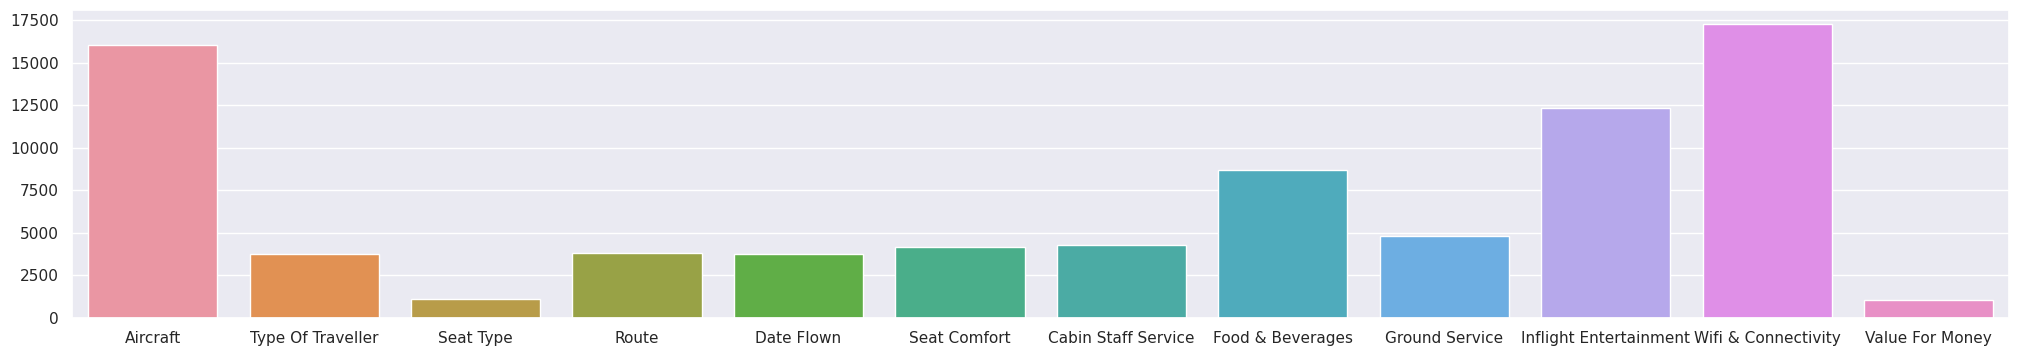

In [10]:
#Plotting null values using matplotlib and seaborn.
null_value_count = []
col_names = []
for col in reviews:
    if reviews[col].isna().sum() > 0:
        null_value_count.append(reviews[col].isna().sum())
    else:
        pass
for col in reviews:
     if reviews[col].isna().sum() > 0:
             col_names.append(col)
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize=(25,4))
sns.barplot(x = col_names, y = null_value_count)

**We have 23171 samples in total.**
* There is too much null values in 'Aircraft', 'Wifi & Connectivity' and 'Inflight Entertainment' columns. So we may consider deleting them.
* 'Food & Beverages' column also contains a lot of null values. Since Food and beverage is a very important thing in all kinds of transports(I mean long way transports) we may drop the rows which 'Food & Beverages' is null.
* We don't clearly sure about how to deal with 'Type of Traveller' and 'Date Flown', because we don't know how they affect people's behaviour when they were writing the reviews.
* If we look the dataset very closely, the 'Route' column is already in 'Review' column, so we are going to drop it.

In [11]:
#Dropping 'Aircraft', 'Wifi & Connectivity', 'Route' and 'Inflight Entertainment' columns.
reviews = reviews.drop(['Aircraft', 'Wifi & Connectivity', 'Route', 'Inflight Entertainment'], axis = 1)

#Dropping the rows which 'Food & Beverages' is null.
reviews = reviews.dropna(axis = 0, subset = ['Food & Beverages'])

In [12]:
reviews.head()

,Unnamed: 0,Airline Name,Review_Title,Review Date,Verified,Review,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,how_was_the_flight
0,0,AB Aviation,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,Solo Leisure,Economy Class,November 2019,4.0,5.0,4.0,4.0,3.0,yes,4
1,1,AB Aviation,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,Solo Leisure,Economy Class,June 2019,2.0,2.0,1.0,1.0,2.0,no,1
2,2,AB Aviation,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Solo Leisure,Economy Class,June 2019,2.0,1.0,1.0,1.0,2.0,no,1
4,4,Adria Airways,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,Couple Leisure,Economy Class,September 2019,1.0,1.0,1.0,1.0,1.0,no,1
5,5,Adria Airways,"""Had very bad experience""",17th September 2019,True,Had very bad experience with rerouted and ca...,Couple Leisure,Economy Class,September 2019,1.0,1.0,1.0,1.0,1.0,no,1


We have 14500 rows left, which is enough for now. Let's set us a limit, that we won't go down below the 10000 rows.

<Axes: >

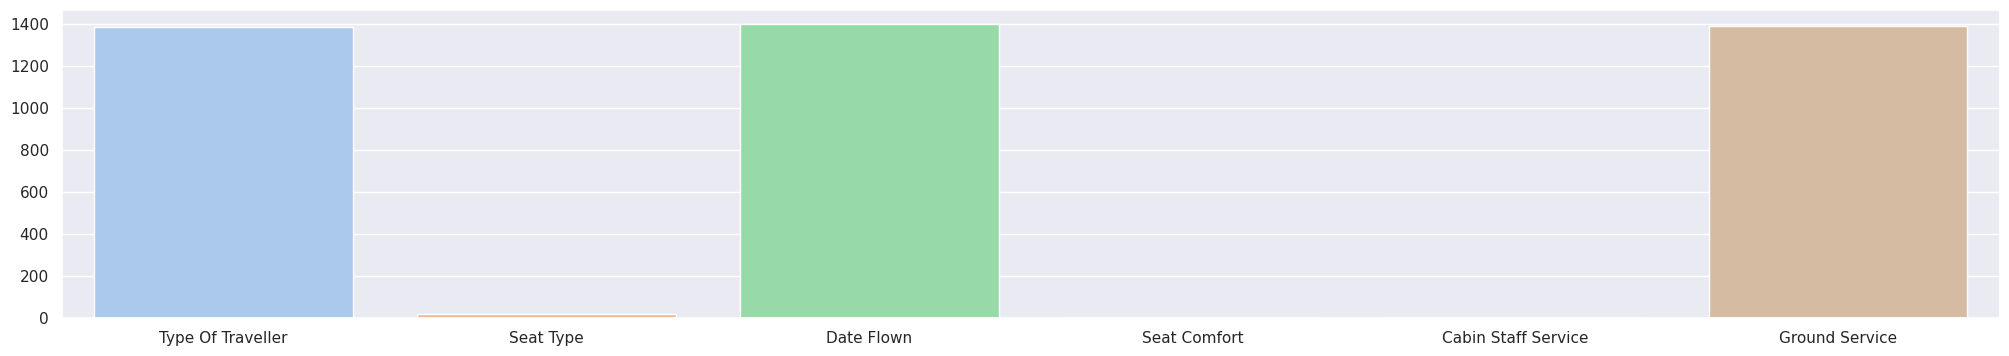

In [13]:
#Let's plot again the null values in final dataset
null_value_count = []
col_names = []
for col in reviews:
    if reviews[col].isna().sum() > 0:
        null_value_count.append(reviews[col].isna().sum())
    else:
        pass
for col in reviews:
     if reviews[col].isna().sum() > 0:
             col_names.append(col)
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize=(25, 4))
sns.barplot(x = col_names, y = null_value_count)

'Seat Type', 'Seat Comfort' and 'Cabin Staff Service' columns have null values, but since they are very little we can't see the exact amount of null values in these columns. The code in below will help us!

In [14]:
reviews.isna().sum()

Unnamed: 0                0
Airline Name              0
Review_Title              0
Review Date               0
Verified                  0
Review                    0
Type Of Traveller      1388
Seat Type                16
Date Flown             1398
Seat Comfort              1
Cabin Staff Service       1
Food & Beverages          0
Ground Service         1392
Value For Money           0
Recommended               0
how_was_the_flight        0
dtype: int64

*  There relatively small amount of samples remain with null values. Let's plot their linear correlations with label (which is 'Overall_Rating' column).
* 'Seat Type' has 16, 'Seat Comfort' has 1 and 'Cabin Staff Service' has 1 null values, so maybe we can fill the values using 'pandas.DataFrame.fillna()' or 'sklearn.impute.SimpleImputer()'.
* 'Type of Traveller', 'Date Flown', 'Ground Service' columns has too many null values to fill. If we fill these values it may affect our model in a bad way.

/tmp/ipykernel_20/880353202.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(reviews.drop('Unnamed: 0', axis = 1).corr(), annot = True, cmap = sns.choose_cubehelix_palette(as_cmap = True), vmin = -1, vmax = 1)


<Figure size 1500x1500 with 0 Axes>

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

<Axes: >

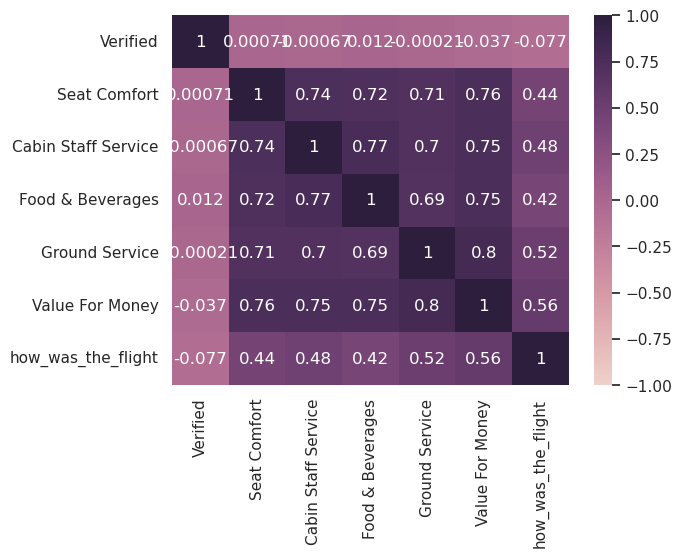

In [15]:
#Let's look at the linear correlations.
plt.figure(figsize=(15,15))
sns.heatmap(reviews.drop('Unnamed: 0', axis = 1).corr(), annot = True, cmap = sns.choose_cubehelix_palette(as_cmap = True), vmin = -1, vmax = 1)

People scored different attributes of companies out of five(e.g. ground service, seat comfort, foods etc.). So we'll try to keep them as possible as we can. Because they can be very powerful when using together, but not alone.

In [16]:
len(reviews['Airline Name'].unique())

448

As you can see there are too many unique values for 'Airline Name' column. If we decide to create dummie variables from it, it would be very terrible choice for us. Because it means that we adding 448 extra features to our dataset and it'll probably end up with decreasing of our model performance and also model will need more time to learn. Remember, we're inside of the some kind of exam and our time is very valuable right now!

In [17]:
reviews = reviews.drop('Airline Name', axis = 1)

<Axes: xlabel='Verified', ylabel='count'>

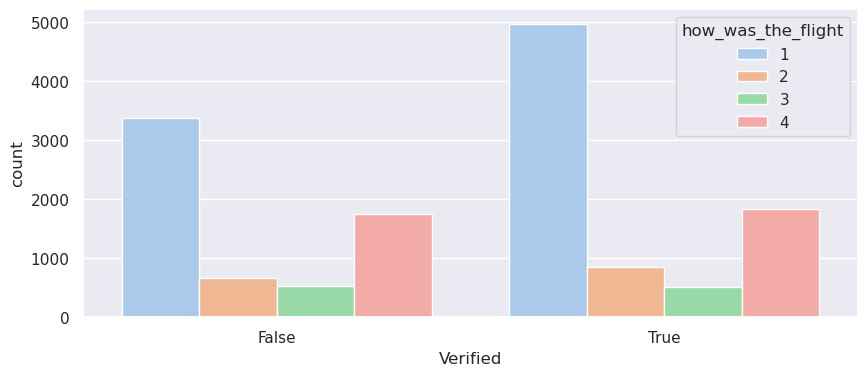

In [18]:
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize = (10, 4))
sns.countplot(data = reviews, x = 'Verified', hue = 'how_was_the_flight')

<Axes: xlabel='Recommended', ylabel='count'>

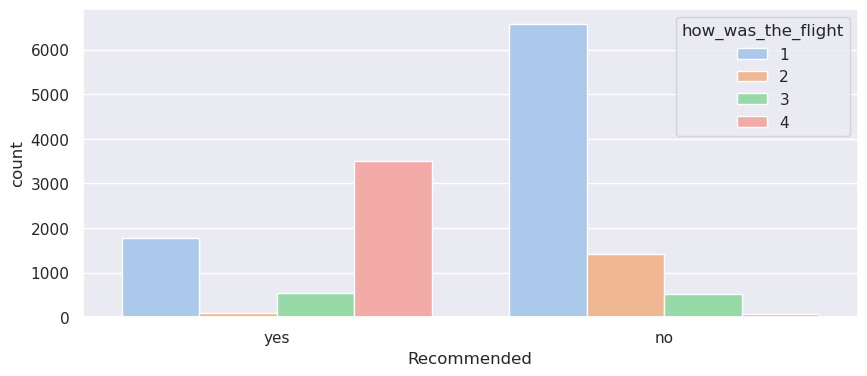

In [19]:
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize = (10, 4))
sns.countplot(data = reviews, x = 'Recommended', hue = 'how_was_the_flight')

About 2000 people write a 'Very bad review' and also recommending the company? That's clearly an outlier case! Let's look at them.

In [20]:
len(reviews[(reviews['Recommended'] == 'yes') & (reviews['how_was_the_flight'] == 1)])

1787

There are 1787 people who has very bad reviews and also recommending the airline company, interesting. Let's look at their reviews.

In [21]:
reviews[(reviews['Recommended'] == 'yes') & (reviews['how_was_the_flight'] == 1)].head(10)

,Unnamed: 0,Review_Title,Review Date,Verified,Review,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,how_was_the_flight
15,15,"""Flight was very comfortable""",4th May 2018,True,Frankfurt to Ljubljana. Flight was very comf...,Business,Economy Class,April 2018,5.0,5.0,5.0,5.0,5.0,yes,1
31,31,"""Clean and fresh aircraft """,29th July 2016,False,Tallinn to Stockholm with Adria Airways. Cle...,Solo Leisure,Economy Class,July 2016,5.0,5.0,5.0,5.0,5.0,yes,1
43,43,Adria Airways customer review,5th January 2015,False,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,Business Class,NaN,4.0,5.0,4.0,NaN,5.0,yes,1
51,51,Adria Airways customer review,6th January 2014,False,Flights from LJU to ZRH and back all on time. ...,NaN,Economy Class,NaN,5.0,5.0,4.0,NaN,4.0,yes,1
113,113,"""Please keep up the excellent work""",26th April 2023,True,Aegean Airlines will remain always my first ...,Solo Leisure,Economy Class,April 2023,5.0,5.0,5.0,5.0,5.0,yes,1
130,130,"""professional cabin crew""",13th November 2022,True,"Best Airline in Europe, professional cabin cr...",Solo Leisure,Economy Class,November 2022,5.0,5.0,3.0,5.0,5.0,yes,1
133,133,"""One of the best airline apps I have tried so ...",26th October 2022,True,Great airline! I fly regularly with Aegean Ai...,Solo Leisure,Economy Class,October 2022,4.0,5.0,4.0,5.0,5.0,yes,1
141,141,"""The best airline in Europe""",18th September 2022,True,"The best airline in Europe, professional cab...",Solo Leisure,Economy Class,September 2022,5.0,5.0,5.0,5.0,5.0,yes,1
147,147,"""Aegean exceeded my expectations""",18th August 2022,True,Aegean exceeded my expectations. Didn't expe...,Solo Leisure,Economy Class,June 2022,5.0,5.0,5.0,5.0,5.0,yes,1
149,149,"""great flight and highly recommended""",11th August 2022,False,Smooth check- in procedure at a very busy At...,Business,Economy Class,August 2022,4.0,5.0,5.0,5.0,5.0,yes,1


It seems, that there is something happened when they submit their reviews. These are clearly good reviews! But we don't know exactly how they rate the company? Maybe it was 3 or it was 4 who knows? Let's drop the rows!

In [22]:
i = reviews[(reviews['Recommended'] == 'yes') & (reviews['how_was_the_flight'] == 1)].index
reviews = reviews.drop(i)

<Axes: xlabel='Recommended', ylabel='count'>

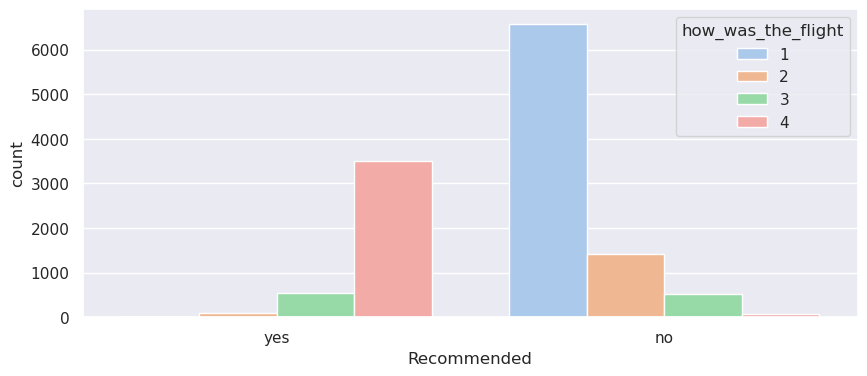

In [23]:
#Let's plot the final results with the same graph!
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize = (10, 4))
sns.countplot(data = reviews, x = 'Recommended', hue = 'how_was_the_flight')

<Axes: xlabel='Seat Type', ylabel='how_was_the_flight'>

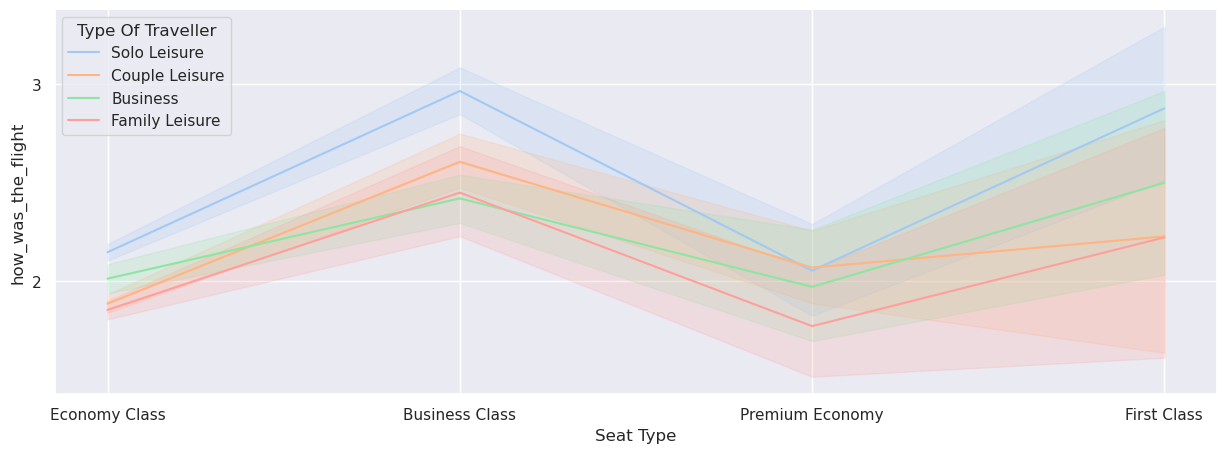

In [24]:
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize = (15, 5))
plt.yticks([0,1,2,3,4,5])
sns.lineplot(data = reviews, x = 'Seat Type', y = 'how_was_the_flight', hue = 'Type Of Traveller')

It seems that Business Class and First Class were pretty satisfied of their flights. So, 'Seat Type' attribute may very important for our model! Lastly, let's look at 'Verified' column closely!

<Axes: xlabel='Verified', ylabel='how_was_the_flight'>

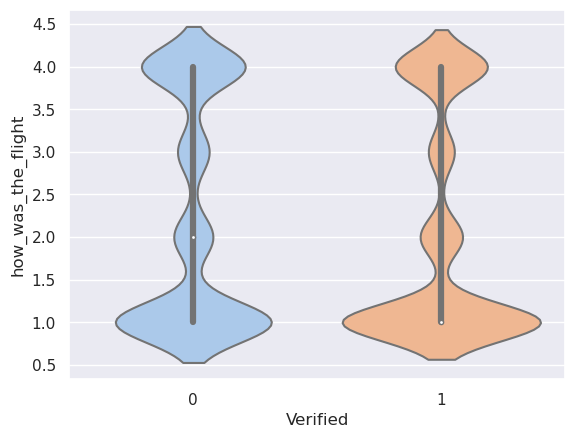

In [25]:
reviews['Verified'] = reviews['Verified'].astype(int)
sns.set_theme(style = 'darkgrid', palette = 'pastel')
sns.violinplot(data=reviews, x = 'Verified', y = 'how_was_the_flight')

Whether reviews verified or not, it seems that they are equally distributed. So, we're not going to use this column as feature.

We're also not going to use the 'Review' column as feature, because if we you both 'Review' and 'Review' column as features (also other columns) it would be very complex model. But, remember! Our intention was to create the simplest and the most accurate model!

In [26]:
reviews = reviews.drop('Review', axis = 1)

It's time to do something with 'Review Title' column, which can be very important for our model. We're going to use **nltk** for this purpose. 

**Note: nltk is a powerful library for NLP(natural language processing).**

In [27]:
#Lowering all the letters and then saving it in the new column(Review Title).

reviews['Review Title'] = reviews['Review_Title'].apply(lambda x: x.lower())

#Removing all punctuation marks.

reviews['Review Title'] = reviews['Review Title'].replace(r'[^\w\s\d+]', '', regex = True)

#Tokenizing the titles.

reviews['Review_Title_Tokenized'] = reviews['Review Title'].apply(lambda x: word_tokenize(x))

#Removing the stopwords.

stopwords = set(stopwords.words('english'))
reviews['Review_Title_Tokenized'] = reviews['Review_Title_Tokenized'].apply(lambda x: [word for word in x if word not in stopwords]) 

#Pos tagging words. (for more info check this: https://en.wikipedia.org/wiki/Part-of-speech_tagging)

reviews['Title_pos_tag'] = reviews['Review_Title_Tokenized'].apply(lambda x: nltk.pos_tag(x))

#It is a function for converting pos tag into wordnet tags.
def to_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('V'):
        return wordnet.VERB
    else:
        return None
reviews['Title_wordnet_tags'] = reviews['Title_pos_tag'].apply(lambda x: [(word, to_wordnet_pos(tag)) for (word, tag) in x])

#Lemmatizing the words. (if you don't know what is lemmatizing check this: https://en.wikipedia.org/wiki/Lemmatisation)

lemmatizer = WordNetLemmatizer()
reviews['Title_lemmatized'] = reviews['Title_wordnet_tags'].apply(lambda x: [lemmatizer.lemmatize(word, tag) if tag is not None else 
                                                                             word for word, tag in x])

#Let's put it together.

reviews['title_filtered'] = reviews['Title_lemmatized'].apply(lambda x: ' '.join(x))

In [28]:
reviews.head(5)

,Unnamed: 0,Review_Title,Review Date,Verified,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,how_was_the_flight,Review Title,Review_Title_Tokenized,Title_pos_tag,Title_wordnet_tags,Title_lemmatized,title_filtered
0,0,"""pretty decent airline""",11th November 2019,1,Solo Leisure,Economy Class,November 2019,4.0,5.0,4.0,4.0,3.0,yes,4,pretty decent airline,"[pretty, decent, airline]","[(pretty, RB), (decent, JJ), (airline, NN)]","[(pretty, r), (decent, a), (airline, n)]","[pretty, decent, airline]",pretty decent airline
1,1,"""Not a good airline""",25th June 2019,1,Solo Leisure,Economy Class,June 2019,2.0,2.0,1.0,1.0,2.0,no,1,not a good airline,"[good, airline]","[(good, JJ), (airline, NN)]","[(good, a), (airline, n)]","[good, airline]",good airline
2,2,"""flight was fortunately short""",25th June 2019,1,Solo Leisure,Economy Class,June 2019,2.0,1.0,1.0,1.0,2.0,no,1,flight was fortunately short,"[flight, fortunately, short]","[(flight, NN), (fortunately, RB), (short, JJ)]","[(flight, n), (fortunately, r), (short, a)]","[flight, fortunately, short]",flight fortunately short
4,4,"""it ruined our last days of holidays""",24th September 2019,1,Couple Leisure,Economy Class,September 2019,1.0,1.0,1.0,1.0,1.0,no,1,it ruined our last days of holidays,"[ruined, last, days, holidays]","[(ruined, VBN), (last, JJ), (days, NNS), (holi...","[(ruined, v), (last, a), (days, n), (holidays,...","[ruin, last, day, holiday]",ruin last day holiday
5,5,"""Had very bad experience""",17th September 2019,1,Couple Leisure,Economy Class,September 2019,1.0,1.0,1.0,1.0,1.0,no,1,had very bad experience,"[bad, experience]","[(bad, JJ), (experience, NN)]","[(bad, a), (experience, n)]","[bad, experience]",bad experience


It looks messy! Let's clean this up a little bit!

In [29]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12713 entries, 0 to 23169
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              12713 non-null  int64  
 1   Review_Title            12713 non-null  object 
 2   Review Date             12713 non-null  object 
 3   Verified                12713 non-null  int64  
 4   Type Of Traveller       11532 non-null  object 
 5   Seat Type               12703 non-null  object 
 6   Date Flown              11525 non-null  object 
 7   Seat Comfort            12712 non-null  float64
 8   Cabin Staff Service     12712 non-null  float64
 9   Food & Beverages        12713 non-null  float64
 10  Ground Service          11532 non-null  float64
 11  Value For Money         12713 non-null  float64
 12  Recommended             12713 non-null  object 
 13  how_was_the_flight      12713 non-null  int64  
 14  Review Title            12713 non-null

In [30]:
#Removing unnecessary columns.
reviews = reviews.drop(['Review_Title','Review Date', 'Date Flown', 'Verified', 'Review Title', 'Review_Title_Tokenized', 'Title_pos_tag', 
                        'Title_wordnet_tags', 'Title_lemmatized', 'Type Of Traveller', 'Unnamed: 0'], axis = 1)

In [31]:
reviews.head()

,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,how_was_the_flight,title_filtered
0,Economy Class,4.0,5.0,4.0,4.0,3.0,yes,4,pretty decent airline
1,Economy Class,2.0,2.0,1.0,1.0,2.0,no,1,good airline
2,Economy Class,2.0,1.0,1.0,1.0,2.0,no,1,flight fortunately short
4,Economy Class,1.0,1.0,1.0,1.0,1.0,no,1,ruin last day holiday
5,Economy Class,1.0,1.0,1.0,1.0,1.0,no,1,bad experience


It looks pretty fine to me! 

One last thing, remember there are a couple features with relatively little amount of null values? It is time to fill NaN's!

In [32]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12713 entries, 0 to 23169
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Seat Type            12703 non-null  object 
 1   Seat Comfort         12712 non-null  float64
 2   Cabin Staff Service  12712 non-null  float64
 3   Food & Beverages     12713 non-null  float64
 4   Ground Service       11532 non-null  float64
 5   Value For Money      12713 non-null  float64
 6   Recommended          12713 non-null  object 
 7   how_was_the_flight   12713 non-null  int64  
 8   title_filtered       12713 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 993.2+ KB


In [33]:
reviews['Seat Type'] = reviews['Seat Type'].fillna('Economy Class') #Since, most of the people flight in Economy Class we're going to fill  null values with this.
reviews['Cabin Staff Service'] = reviews['Cabin Staff Service'].fillna(reviews['Cabin Staff Service'].mode())
reviews['Seat Comfort'] = reviews['Seat Comfort'].fillna(reviews['Seat Comfort'].mode())

"""
There are more than 1000 null values for 'Ground Service' column, it is not that many, because it's very 'sensitive' feature, wrong 'fillings'
may decrease model's performance. So, we're going to drop the rows where 'Ground Service's values is null!

"""
reviews = reviews.dropna(subset = 'Ground Service', axis = 0)

In [34]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11532 entries, 0 to 23169
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Seat Type            11532 non-null  object 
 1   Seat Comfort         11532 non-null  float64
 2   Cabin Staff Service  11532 non-null  float64
 3   Food & Beverages     11532 non-null  float64
 4   Ground Service       11532 non-null  float64
 5   Value For Money      11532 non-null  float64
 6   Recommended          11532 non-null  object 
 7   how_was_the_flight   11532 non-null  int64  
 8   title_filtered       11532 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 900.9+ KB


Perfect! There is no more null values in the dataset!

# Feature Engineering

As you may already know, machine can only understand numbers. So, we have to convert categorical features into numbers.

In [35]:
dummie_seat_type = pd.get_dummies(reviews['Seat Type'])
reviews_new = pd.concat([reviews, dummie_seat_type], axis = 1)
reviews_new = reviews_new.drop('Seat Type', axis = 1)
reviews_new.reset_index(drop = True)

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,how_was_the_flight,title_filtered,Business Class,Economy Class,First Class,Premium Economy
0,4.0,5.0,4.0,4.0,3.0,yes,4,pretty decent airline,0,1,0,0
1,2.0,2.0,1.0,1.0,2.0,no,1,good airline,0,1,0,0
2,2.0,1.0,1.0,1.0,2.0,no,1,flight fortunately short,0,1,0,0
3,1.0,1.0,1.0,1.0,1.0,no,1,ruin last day holiday,0,1,0,0
4,1.0,1.0,1.0,1.0,1.0,no,1,bad experience,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11527,2.0,2.0,1.0,1.0,1.0,no,1,think meal include,0,1,0,0
11528,2.0,2.0,1.0,2.0,1.0,no,1,would refund tax,0,1,0,0
11529,3.0,4.0,1.0,1.0,2.0,no,1,300 saving absolutely worth,0,1,0,0
11530,2.0,4.0,2.0,1.0,2.0,no,2,recommend anyone,0,1,0,0


In [36]:
lb_enc = LabelEncoder() #LabelEncoder helps us to convert categorical features into numbers
reviews_new['Recommended'] = lb_enc.fit_transform(reviews_new['Recommended'])
reviews_new['Recommended'] = reviews_new['Recommended'].astype(int)

In [37]:
reviews_new.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11532 entries, 0 to 23169
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Seat Comfort         11532 non-null  float64
 1   Cabin Staff Service  11532 non-null  float64
 2   Food & Beverages     11532 non-null  float64
 3   Ground Service       11532 non-null  float64
 4   Value For Money      11532 non-null  float64
 5   Recommended          11532 non-null  int64  
 6   how_was_the_flight   11532 non-null  int64  
 7   title_filtered       11532 non-null  object 
 8   Business Class       11532 non-null  uint8  
 9   Economy Class        11532 non-null  uint8  
 10  First Class          11532 non-null  uint8  
 11  Premium Economy      11532 non-null  uint8  
dtypes: float64(5), int64(2), object(1), uint8(4)
memory usage: 855.9+ KB


As you can see, all columns are just consist of numbers, except 'title_filtered' column. Let's convert it too using CountVectorizer.

In [38]:
#CountVectorizer converts a collection of text documents to a matrix of token counts. 

vectorizer = CountVectorizer(min_df = 0.001) #Setting min_df = 0.001 means, that any word which can used under 0.001 of samples will be removed.
#You can try, TfidfVectorizer too.(see, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

vectorized = vectorizer.fit_transform(reviews_new['title_filtered'])
vectorized_df = pd.DataFrame(vectorized.toarray(), columns = vectorizer.get_feature_names_out())
#We just created a pandas dataframe with all the worlds in 'title_filtered' column. Each word represents as a column.

In [39]:
reviews_new = reviews_new.reset_index(drop = True)
review_final = pd.concat([reviews_new, vectorized_df], axis = 1) #Concatinating our 'main' dataframe with 'vectorized_df'.
review_final = review_final.drop('title_filtered', axis = 1) #We don't need this column anymore

In [40]:
#We are going to use MinMaxScaler for feature scaling, because MultinomialNaiveBayes doesn't allow negative values.
scaler = MinMaxScaler()
X = scaler.fit_transform(review_final.drop('how_was_the_flight', axis = 1))
y = review_final['how_was_the_flight']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 6)

# Model Selection, Training and Evaluating.

**We are going to using four different algorithms.**
* Multinomial Naive Bayes - *This is very good when dealing with text data.*
* Gradient Boosting Classifier - *GB can handle many type of data(spoiler alert: you'll see)*
* Voting Classifier - *Using voting classifier we can combine different models.*

In [41]:
mnb = MultinomialNB()
gb_clf = GradientBoostingClassifier()
vot_clf = VotingClassifier(estimators = [('mnb', mnb), ('gb_clf', gb_clf)], voting = 'soft') 
#Setting 'voting' parameter to soft will make the classifier to classify by probobalities.

Let's write a for loop for get accuracy score for each classifier automatically. 

In [42]:
model_names = ['MultinomialNB', 'GradientBoost', 'VotingClassifier']
models = [mnb, gb_clf, vot_clf]
count = 0 
for model in models:
    cvalscore = cross_val_score(model, X_train,y_train, scoring = 'accuracy', cv = 5)
    print('Accuracy of {}: '.format(model_names[count]), cvalscore.mean())
    count = count + 1

Accuracy of MultinomialNB:  0.7739837398373984
Accuracy of GradientBoost:  0.821788617886179
Accuracy of VotingClassifier:  0.8130081300813007


What did I just said? Gradient Boost is very effective in many types of data. There are other libraries for Gradient Boosting too such as, XGBoost, CatBoost etc.

For more info about how the Gradient Boost works, check this - *https://www.geeksforgeeks.org/ml-gradient-boosting/*

In [43]:
#Let's Gradient Boost fit to the data and then measure the accuracy score.
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
print('Accuracy of GradientBoost: ', accuracy_score(y_test, y_pred))

Accuracy of GradientBoost:  0.8279150411790204


Accuracy, is a good and simple metric to understand how the model performs, but in some cases it can be insufficient. So, we're going to deep dive and we'll try to detect errors that made by Gradient Boost.

Text(0.5, 1.0, 'Confusion Matrix')

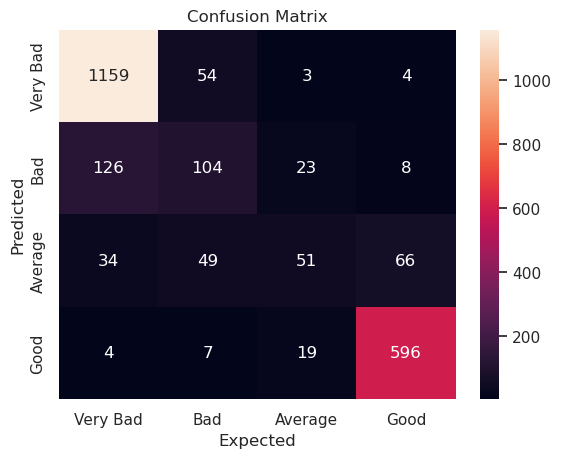

In [44]:
classes = ['Very Bad', 'Bad', 'Average', 'Good']
scores = confusion_matrix(y_test, y_pred)
sns.set_theme(palette = 'pastel')
sns.heatmap(scores, annot = True, fmt = 'd', xticklabels = classes, yticklabels = classes)
plt.xlabel('Expected')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')

While predicting 'Average' and 'Bad' columns our model actually done bad job. It's almost like flipping a coin.(50/50)

In [45]:
#Precision for 'Bad' reviews.
precision_bad = 104/scores[1,:].sum()
#Recall for 'Bad' reviews.
recall_bad = 104/scores[:,1].sum()

#Precision for 'Average' class
precision_avg = 51/scores[2, :].sum()
#Recall for 'Average' class
recall_avg = 51/scores[:, 2].sum()

In [46]:
#Let's create a dataframe for easy visualizing
prc_avg_dict = {
    'class': ['Bad', 'Average'], 'precision': [precision_bad, precision_avg], 'recall': [recall_bad, recall_avg]
}
prc_avg = pd.DataFrame(data = prc_avg_dict)
prc_avg

,class,precision,recall
0,Bad,0.398467,0.485981
1,Average,0.255000,0.531250


The devostating truth! Even if the model looked pretty good with evaluation of accuracy score, it is really bad, especially for these two classes. But again, our goal was to detect 'Very Bad' reviews and delete them. When it comes to the 'Very Bad' reviews, our model did relatively pretty good job!

In [47]:
#Precision for 'Very Bad' reviews.
precision_very_bad = 1158/scores[0,:].sum()
#Recall for 'Very Bad' reviews.
recall_very_bad = 1158/scores[:,0].sum()

#Let's update the dataframe
new_instance = {'class': ['Very Bad'], 'precision': [precision_very_bad], 'recall': [recall_very_bad]}
new_instance_df = pd.DataFrame(data = new_instance)
prc_avg_full = pd.concat([prc_avg, new_instance_df], axis = 0)
prc_avg_full = prc_avg_full.reset_index(drop = True)
prc_avg_full

,class,precision,recall
0,Bad,0.398467,0.485981
1,Average,0.255000,0.531250
2,Very Bad,0.949180,0.875283


0.94 Precision and 0.87 Recall is pretty good! Maybe we can pass the exam. Take this 'exam' and try to beat me(You'll probably beat me I'm a rookie!)

# THE END

**If you like this notebook, please upvote for other people to see. Thank you everyone who read the entire notebook!**